In [1]:
# --- Parameters & seeds ---
# tags: parameters
import os, random, numpy as np
from pathlib import Path

# Determinism
os.environ["TZ"] = "UTC"
random.seed(12345)
np.random.seed(12345)

# Parameters (can be overridden via environment or Papermill)
RAW_DIR = Path(os.getenv("RAW_DIR", "data/raw"))
OUT_DIR = Path(os.getenv("OUT_DIR", "data/processed"))
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Explicit input paths expected by the rest of the notebook
GENERIC      = RAW_DIR / "Generic_Data.xlsx"
PERSONALISED = RAW_DIR / "Personal_Data.xlsx"
PERSONAL     = PERSONALISED  # alias for safety


In [2]:
import warnings
# --- Cell 0: imports, paths, and small helpers ---

import re, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportion_confint

# Optional fallback if a GLM has separation
try:
    from sklearn.linear_model import LogisticRegression
    HAVE_SKLEARN = True
except Exception:
    HAVE_SKLEARN = False

plt.rcParams.update({"figure.dpi": 120, "savefig.dpi": 300, "font.size": 11})

DATA_DIR   = Path(".")
GENERIC    = DATA_DIR / "Generic_Data.xlsx"   # Neutral
PERSONALISED = DATA_DIR / "Personal_Data.xlsx"  # Customised
OUT_DIR    = Path("./results"); OUT_DIR.mkdir(exist_ok=True)

def wilson_ci(k, n, alpha=0.05):
    """Wilson interval for a binomial proportion."""
    if n == 0:
        return (np.nan, np.nan)
    lo, hi = proportion_confint(k, n, alpha=alpha, method="wilson")
    return lo, hi

def delta_method_threshold(b0, b1, cov_2x2, z=1.96):
    """
    Threshold x50 = -b0/b1 with delta-method SE and CI from a 2x2 covariance matrix.
    Returns (x50, se, lo, hi). If slope ~ 0, returns NaNs for safety.
    """
    if abs(b1) < 1e-8:
        return (np.nan, np.nan, np.nan, np.nan)
    x = -b0 / b1
    g0, g1 = -1.0/b1, b0/(b1**2)
    var = g0**2 * cov_2x2[0,0] + g1**2 * cov_2x2[1,1] + 2*g0*g1*cov_2x2[0,1]
    se = math.sqrt(var) if var >= 0 else np.nan
    return (x, se, x - z*se, x + z*se)

try:
    from statsmodels.tools.sm_exceptions import PerfectSeparationError, PerfectSeparationWarning
except Exception:
    from statsmodels.tools.sm_exceptions import PerfectSeparationError
    class PerfectSeparationWarning(Warning):
        pass


In [3]:
# --- Cell 1: read wide Excel, stack repeated column blocks into one tidy table ---

BASE_COLS = ["ParticipantID","Trial","GeoLOD","DeltaGeoLOD","DistanceBin",
             "MotionType","Phase","Detected","RT_ms",
             "AvgMS_Before","AvgMS_After","TimeStim","TimeResp"]

def stack_wide_excel(path: Path, avatar_label: str) -> pd.DataFrame:
    dfw = pd.read_excel(path, sheet_name=0)
    # find suffixes: '', '.1', '.2', ...
    suffixes = set()
    pat = re.compile(r"^([A-Za-z_]+)(?:\.(\d+))?$")
    for col in dfw.columns:
        m = pat.match(str(col))
        if m:
            suffixes.add(m.group(2) or "")

    frames = []
    for suf in sorted(suffixes, key=lambda s: (s == "" and -1) or int(s)):
        cols = {}
        for c in BASE_COLS:
            name = c if suf == "" else f"{c}.{suf}"
            if name in dfw.columns:
                cols[c] = name
        # must have at least Phase and GeoLOD to be meaningful
        if "Phase" not in cols or "GeoLOD" not in cols:
            continue
        sub = dfw[list(cols.values())].copy()
        sub.columns = list(cols.keys())

        # drop header echoes and junk rows
        sub = sub[sub["Phase"].isin(["MoCS","WarmUp"])]
        sub = sub[sub["GeoLOD"].astype(str).str.match(r"^\d+$")]

        # coerce core types
        for num in ["Trial","GeoLOD","Detected","RT_ms","AvgMS_Before",
                    "AvgMS_After","TimeStim","TimeResp"]:
            sub[num] = pd.to_numeric(sub[num], errors="coerce")

        # simple cleanups
        sub["ParticipantID"] = sub["ParticipantID"].astype(str).str.strip()
        # map motion; in your logs sometimes "static" appeared — treat it as Idle
        sub["motion"] = sub["MotionType"].where(sub["MotionType"].isin(["Idle","Walking"]))
        sub.loc[sub["MotionType"].astype(str).str.lower() == "static", "motion"] = "Idle"

        sub["avatar"] = avatar_label
        frames.append(sub)

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

neutral = stack_wide_excel(GENERIC, "Neutral")
custom  = stack_wide_excel(PERSONALISED, "Customised")
raw = pd.concat([neutral, custom], ignore_index=True)

print("Rows loaded:", len(raw), "| participants:", raw["ParticipantID"].nunique())
raw.head()

Rows loaded: 4720 | participants: 10


,ParticipantID,Trial,GeoLOD,DeltaGeoLOD,DistanceBin,MotionType,Phase,Detected,RT_ms,AvgMS_Before,AvgMS_After,TimeStim,TimeResp,motion,avatar
0,P01,1,0,0,3m,Idle,WarmUp,0,0.000,0.000,22.867,1.708077e+07,1.708078e+07,Idle,Neutral
1,P01,2,2,2,3m,Idle,WarmUp,0,0.000,22.114,21.334,1.708078e+07,1.708079e+07,Idle,Neutral
2,P01,3,4,4,3m,Idle,WarmUp,1,4502.554,20.561,23.389,1.708079e+07,1.708079e+07,Idle,Neutral
3,P01,4,6,6,3m,Idle,WarmUp,1,5660.240,22.051,22.673,1.708079e+07,1.708080e+07,Idle,Neutral
4,P01,5,7,7,3m,Idle,WarmUp,1,5837.623,21.736,21.396,1.708080e+07,1.708080e+07,Idle,Neutral


In [4]:
# --- Cell 2: MoCS filter, return-validation, and model dataset (LOD 1–7 only) ---

# Keep only the main phase
mocs = raw[raw["Phase"] == "MoCS"].copy()

# Sort within participant in temporal order
mocs = mocs.sort_values(["ParticipantID","Trial","TimeStim"])

# Drop physiologically implausible / anticipatory responses
mask_fast = (mocs["Detected"] == 1) & (mocs["RT_ms"].notna()) & (mocs["RT_ms"] < 150)
n_fast = int(mask_fast.sum())
mocs = mocs.loc[~mask_fast].copy()

# === Robust frame-time QC (median + 3*MAD; Methods 5.6.3/5.7) ===
def robust_limit(s):
    med = s.median()
    mad = (s - med).abs().median()
    return med + 3*mad

lims = (
    mocs.groupby("ParticipantID")[["AvgMS_Before","AvgMS_After"]]
        .apply(lambda g: pd.Series({
            "lim_before": robust_limit(g["AvgMS_Before"]),
            "lim_after":  robust_limit(g["AvgMS_After"])
        }))
)
mocs = mocs.join(lims, on="ParticipantID")

bad_timing = (mocs["AvgMS_Before"] > mocs["lim_before"]) | (mocs["AvgMS_After"] > mocs["lim_after"])
n_bad_timing = int(bad_timing.sum())
mocs = mocs.loc[~bad_timing].drop(columns=["lim_before","lim_after"])

# === Return-validation (as in Methods; do NOT count as FA) ===
# If a test segment (LOD>0) has a click but the immediate return LOD0 has NO click,
# treat the test click as unreliable and drop it.
mocs["next_GeoLOD"]   = mocs.groupby("ParticipantID")["GeoLOD"].shift(-1)
mocs["next_Detected"] = mocs.groupby("ParticipantID")["Detected"].shift(-1)

rv_mask = (
    (mocs["GeoLOD"] > 0) &
    (mocs["Detected"] == 1) &
    (mocs["next_GeoLOD"] == 0) &
    (mocs["next_Detected"].fillna(0).astype(int) == 0)
)

dropped_by_rv = int(rv_mask.sum())
mocs_clean = mocs.loc[~rv_mask].copy()

# LOD0 rows are kept only for reporting (FA pre-test; return-validation rate); modelling uses LOD 1–7
lod0 = mocs_clean[mocs_clean["GeoLOD"] == 0].copy()
model_df = mocs_clean[mocs_clean["GeoLOD"] > 0].copy()
model_df["detect"] = model_df["Detected"].fillna(0).astype(int)

print({
    "MoCS_rows": len(mocs),
    "dropped_anticipation": n_fast,
    "dropped_bad_timing": n_bad_timing,
    "dropped_by_return_validation": dropped_by_rv,
    "LOD0_rows": len(lod0),
    "model_rows_LOD_1_7": len(model_df)
})

{'MoCS_rows': 3760, 'dropped_anticipation': 0, 'dropped_bad_timing': 760, 'dropped_by_return_validation': 129, 'LOD0_rows': 1879, 'model_rows_LOD_1_7': 1752}


In [5]:
# --- Cell 2b: refined FA/Miss (pair Test->Return; pre-test FA only) ---

# We start from the MoCS dataframe you built in Cell 2 (mocs: BEFORE rv-drop; mocs_clean/model_df also available)
m = mocs.copy().sort_values(["ParticipantID","Trial","TimeStim"])

# Identify segment types
m["is_test"]  = m["GeoLOD"] > 0
m["is_lod0"]  = m["GeoLOD"] == 0

# Neighbouring segment metadata
m["next_GeoLOD"]   = m.groupby("ParticipantID")["GeoLOD"].shift(-1)
m["next_Detected"] = m.groupby("ParticipantID")["Detected"].shift(-1)
m["prev_GeoLOD"]   = m.groupby("ParticipantID")["GeoLOD"].shift(+1)

# --- Return-validation % (proportion of detected tests with a confirming click on the immediate return LOD0)
detected_tests = m[(m["is_test"]) & (m["Detected"] == 1) & (m["next_GeoLOD"] == 0)].copy()
detected_tests["rv_has_click"] = detected_tests["next_Detected"].fillna(0).astype(int)

return_validation_pct = (
    detected_tests.groupby("ParticipantID")["rv_has_click"]
    .mean()
    .mul(100.0)
    .rename("return_validation_pct")
)

# --- False Alarms (FA) on pre-test LOD0 only (i.e., LOD0 segments whose next is a test segment)
pretest_lod0 = m[(m["is_lod0"]) & (m["next_GeoLOD"] > 0)].copy()
pretest_lod0["fa_click"] = pretest_lod0["Detected"].fillna(0).astype(int)

fa_pretest_pct = (
    pretest_lod0.groupby("ParticipantID")["fa_click"]
    .mean()
    .mul(100.0)
    .rename("fa_pretest_pct")
)

# --- Refined miss rate on TESTS (after rv-filter), i.e., proportion of tests without a detection
# Use model_df built in Cell 2 (LOD 1–7 only, after return-validation drop)
miss_rate_refined_pct = (
    model_df.groupby("ParticipantID")["detect"]
    .apply(lambda s: (1.0 - s.mean())*100.0)
    .rename("miss_rate_refined_pct")
)

# Collect to merge in Cell 3
qc_refined_rates = (
    pd.concat([return_validation_pct, fa_pretest_pct, miss_rate_refined_pct], axis=1)
      .reset_index()
)

qc_refined_rates.head()

,ParticipantID,return_validation_pct,fa_pretest_pct,miss_rate_refined_pct
0,P01,33.333333,48.214286,46.391753
1,P02,76.595745,85.714286,39.560440
2,P03,39.393939,58.928571,53.092784
3,P04,71.153846,100.000000,44.303797
4,P05,53.125000,60.714286,51.677852


In [6]:
# --- Cell 3: simple QC summary per participant ---

def block_present(g, av, mo):
    return ((g["avatar"] == av) & (g["motion"] == mo)).any()

qc_rows = []
for pid, g in mocs_clean.groupby("ParticipantID"):
    # presence of the 4 cells
    blocks = {(av, mo): block_present(g, av, mo)
              for av in ["Neutral","Customised"] for mo in ["Idle","Walking"]}
    blocks_complete = int(sum(blocks.values()))

    # Miss rate on tests (post return-validation; consistent with Cell 2b)
    gt = model_df[model_df["ParticipantID"] == pid]
    miss_rate = float((1.0 - gt["detect"].mean())*100.0) if len(gt) else float("nan")

    qc_rows.append({
        "ParticipantID": pid,
        "has_Neutral_Idle":     int(blocks[("Neutral","Idle")]),
        "has_Neutral_Walking":  int(blocks[("Neutral","Walking")]),
        "has_Customised_Idle":  int(blocks[("Customised","Idle")]),
        "has_Customised_Walking": int(blocks[("Customised","Walking")]),
        "blocks_complete": blocks_complete,
        # Legacy column will be replaced with refined return-validation below
        "miss_rate_pct": miss_rate
    })

qc = pd.DataFrame(qc_rows).sort_values("ParticipantID")

# Confirmatory set = participants with all 4 blocks (everyone, per current dataset)
qc["include_confirmatory"] = (qc["blocks_complete"] == 4)

qc = qc.merge(qc_refined_rates, on="ParticipantID", how="left")

# return_validation_pct: confirming-click rate on the immediate return LOD0 after detected tests
# fa_pretest_pct: false alarms on pre-test LOD0 only
qc = qc.rename(columns={
    # keep names as-is from merge; just ensure they're present
    # "return_validation_pct": "return_validation_pct",
    # "fa_pretest_pct": "fa_pretest_pct",
    # "miss_rate_refined_pct": "miss_rate_refined_pct"
})

# For the paper’s QC table, show the following subset:
qc_paper_subset = qc[[
    "ParticipantID", "blocks_complete", "return_validation_pct", "miss_rate_pct", "include_confirmatory"
]].copy()

# Round for display
for c in ["return_validation_pct","miss_rate_pct"]:
    qc_paper_subset[c] = qc_paper_subset[c].round(2)

qc, qc_paper_subset

# ----

# --- Cell 14: Refined FA & Miss computation (using mocs_clean) + canonical QC export ---

# Full QC with refined fields and clear names for camera-ready copy
qc_out = qc.copy()

# Save canonical QC summary (clear names) and a “paper subset”
qc_out.to_excel(OUT_DIR / "qc_summary.xlsx", index=False)
qc_paper_subset.to_excel(OUT_DIR / "qc_summary_paper_subset.xlsx", index=False)

print("QC summaries saved to:",
      OUT_DIR / "qc_summary.xlsx",
      "and",
      OUT_DIR / "qc_summary_paper_subset.xlsx")


QC summaries saved to: results\qc_summary.xlsx and results\qc_summary_paper_subset.xlsx


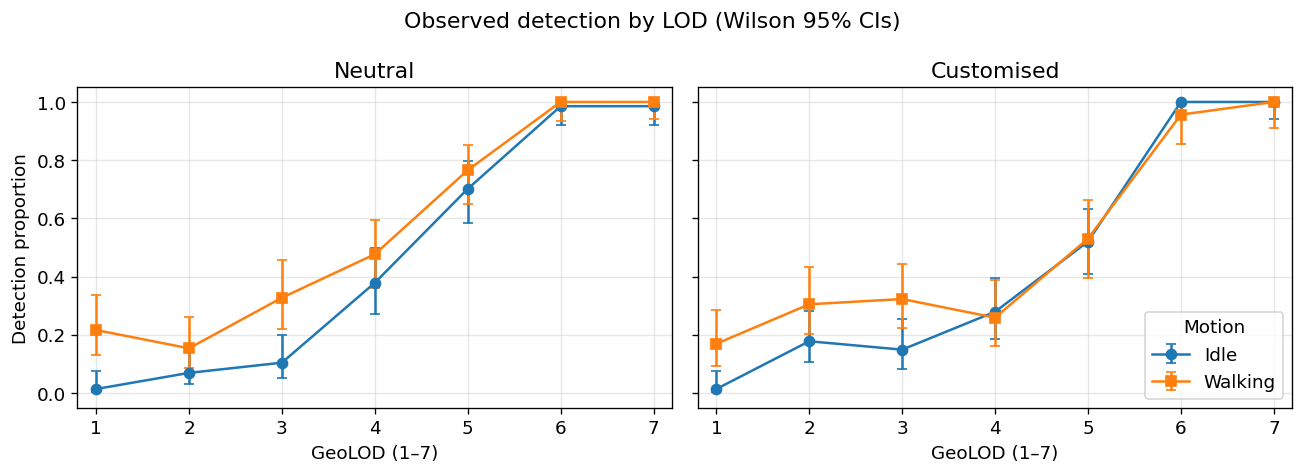

In [7]:
# --- Cell 4: detection proportions and CIs per LOD, per avatar x motion ---

rows = []
for (av, mo, lod), g in model_df.groupby(["avatar","motion","GeoLOD"]):
    n = len(g); k = int(g["detect"].sum())
    p = k/n if n else np.nan
    lo, hi = wilson_ci(k, n) if n else (np.nan, np.nan)
    rows.append({"avatar": av, "motion": mo, "GeoLOD": int(lod),
                 "n": n, "k": k, "p": p, "p_lo": lo, "p_hi": hi})
desc = pd.DataFrame(rows).sort_values(["avatar","motion","GeoLOD"])
desc.to_csv(OUT_DIR/"descriptives_by_lod.csv", index=False)
desc.head()

# ----

# --- Cell 4b: plot descriptives (two panels) ---

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

for ax, av in zip(axes, ["Neutral","Customised"]):
    sub = desc[desc["avatar"] == av]
    for mo, marker, label in [("Idle", "o-", "Idle"), ("Walking", "s-", "Walking")]:
        s = sub[sub["motion"] == mo].sort_values("GeoLOD")
        if s.empty: continue

        x  = s["GeoLOD"].to_numpy(float)
        p  = s["p"].to_numpy(float)
        lo = s["p_lo"].to_numpy(float)
        hi = s["p_hi"].to_numpy(float)

        # keep things well-behaved for errorbar()
        p  = np.clip(p,  0, 1)
        lo = np.clip(lo, 0, 1)
        hi = np.clip(hi, 0, 1)
        lo = np.minimum(lo, p)
        hi = np.maximum(hi, p)
        yerr = np.vstack([p - lo, hi - p])

        ax.errorbar(x, p, yerr=yerr, fmt=marker, capsize=3, label=label)

    ax.set_title(av); ax.set_xlabel("GeoLOD (1–7)")
    ax.set_xlim(0.8, 7.2); ax.set_ylim(-0.05, 1.05); ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Detection proportion")
axes[1].legend(title="Motion", loc="lower right")
plt.suptitle("Observed detection by LOD (Wilson 95% CIs)")
plt.tight_layout()
plt.savefig(OUT_DIR/"fig_descriptives_by_lod.png", bbox_inches="tight")
plt.show()


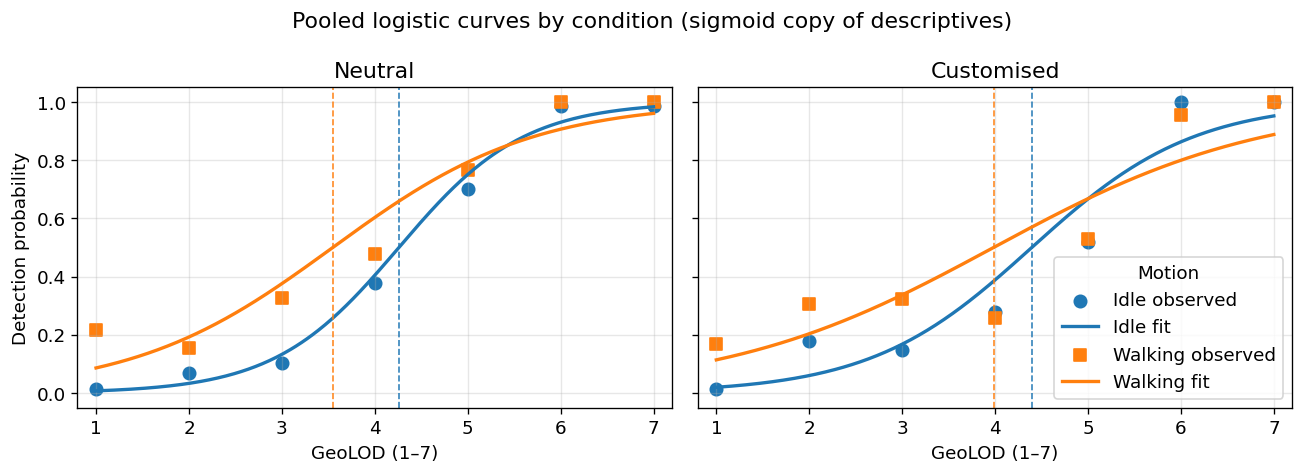

,avatar,motion,method,x50,x50_lo,x50_hi
2,Customised,Idle,glm_cluster,4.394794,3.822487,4.967101
3,Customised,Walking,glm_cluster,3.983244,2.783635,5.182854
0,Neutral,Idle,glm_cluster,4.259201,3.945200,4.573201
1,Neutral,Walking,glm_cluster,3.547236,2.918012,4.176460


In [8]:
# --- Sigmoid copy of "descriptives by LOD" (two panels with fitted curves) ---

def pooled_logistic_with_fallback(g_sub):
    """
    Fit pooled logistic detect ~ GeoLOD for a subset (avatar x motion).
    - Try Binomial GLM with cluster-robust SEs (clusters = ParticipantID)
    - If perfect separation is detected, fall back to ridge-regularised GLM (no CI)
    Returns dict with b0, b1, x50, (optional) CI, and a 'method' label.
    """
    g = g_sub.dropna(subset=["GeoLOD","detect","ParticipantID"]).copy()
    if g.empty or g["GeoLOD"].nunique() < 2 or g["detect"].nunique() < 2:
        return {"ok": False, "reason": "insufficient variation"}

    try:
        with warnings.catch_warnings(record=True) as wlist:
            warnings.simplefilter("always")
            X = sm.add_constant(g["GeoLOD"].astype(float))
            y = g["detect"].astype(int)
            fit = sm.GLM(y, X, family=sm.families.Binomial()).fit(
                cov_type="cluster", cov_kwds={"groups": g["ParticipantID"]}
            )
            sep = any(isinstance(w.message, PerfectSeparationWarning) or
                      ("Perfect separation" in str(w.message))
                      for w in wlist)
        if not sep:
            b0 = float(fit.params["const"])
            b1 = float(fit.params["GeoLOD"])
            cov = fit.cov_params().loc[["const","GeoLOD"],["const","GeoLOD"]].to_numpy()
            x50, se, lo, hi = delta_method_threshold(b0, b1, cov)
            return {"ok": True, "b0": b0, "b1": b1, "x50": x50,
                    "x50_lo": lo, "x50_hi": hi, "method": "glm_cluster"}
    except Exception:
        pass

    # Fallback: ridge-regularised GLM (no CI)
    try:
        fit_r = sm.GLM(y, X, family=sm.families.Binomial()).fit_regularized(
            alpha=1.0, L1_wt=0.0, maxiter=2000
        )
        b0 = float(fit_r.params["const"])
        b1 = float(fit_r.params["GeoLOD"])
        x50 = (-b0 / b1) if abs(b1) > 1e-8 else np.nan
        return {"ok": True, "b0": b0, "b1": b1, "x50": x50,
                "x50_lo": np.nan, "x50_hi": np.nan, "method": "glm_ridge_alpha1"}
    except Exception as e:
        return {"ok": False, "reason": f"fit_failed: {e}"}

# Style map
STYLE = {
    "Idle":    {"marker": "o", "linestyle": "-", "label": "Idle",    "color": "C0"},  # blue
    "Walking": {"marker": "s", "linestyle": "-", "label": "Walking", "color": "C1"},  # orange
}

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
rows_for_table = []

for ax, av in zip(axes, ["Neutral", "Customised"]):
    g_av = model_df[model_df["avatar"] == av]

    for mo in ["Idle", "Walking"]:
        g_cond = g_av[g_av["motion"] == mo]
        res = pooled_logistic_with_fallback(g_cond)

        # Observed points (means) for context
        obs = (g_cond.groupby("GeoLOD")["detect"]
                      .mean().reindex(range(1,8)).dropna())
        ax.scatter(
            obs.index, obs.values,
            marker=STYLE[mo]["marker"], s=55,
            color=STYLE[mo]["color"],
            label=f"{STYLE[mo]['label']} observed"
        )

        if res.get("ok", False) and np.isfinite(res["x50"]):
            b0, b1 = res["b0"], res["b1"]
            xs = np.linspace(1, 7, 400)
            ps = 1 / (1 + np.exp(-(b0 + b1*xs)))

            ax.plot(
                xs, ps,
                linestyle=STYLE[mo]["linestyle"], linewidth=2,
                color=STYLE[mo]["color"],
                label=f"{STYLE[mo]['label']} fit"
            )
            # Vertical x50 line for that curve
            ax.axvline(res["x50"], ls="--", lw=1, color=STYLE[mo]["color"], alpha=0.9)

            rows_for_table.append({
                "avatar": av, "motion": mo, "method": res["method"],
                "x50": res["x50"], "x50_lo": res.get("x50_lo"), "x50_hi": res.get("x50_hi")
            })
        else:
            rows_for_table.append({
                "avatar": av, "motion": mo, "method": res.get("reason","fit_failed"),
                "x50": np.nan, "x50_lo": np.nan, "x50_hi": np.nan
            })

    ax.set_title(av)
    ax.set_xlabel("GeoLOD (1–7)")
    ax.set_xlim(0.8, 7.2)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Detection probability")
axes[1].legend(title="Motion", loc="lower right")
plt.suptitle("Pooled logistic curves by condition (sigmoid copy of descriptives)")
plt.tight_layout()
plt.savefig(OUT_DIR / "fig_sigmoids_by_lod.png", bbox_inches="tight")
plt.show()

pooled_cond_thr = (pd.DataFrame(rows_for_table)
                   .sort_values(["avatar","motion"]))
pooled_cond_thr.to_csv(OUT_DIR / "pooled_thresholds_by_condition.csv", index=False)
pooled_cond_thr


In [9]:
# --- Cell 5: estimate x50 per participant × (avatar, motion) with separation-safe fallback ---

def fit_x50_glm(g):
    """
    Try a standard Binomial GLM (logit).
    Returns dict with x50 and CI; raises ValueError if separation is detected.
    """
    with warnings.catch_warnings(record=True) as wlist:
        warnings.simplefilter("always")
        fit = smf.glm("detect ~ GeoLOD", data=g, family=sm.families.Binomial()).fit()
        # Did statsmodels warn about separation?
        sep = any(isinstance(w.message, PerfectSeparationWarning) or
                  ("Perfect separation" in str(w.message))
                  for w in wlist)
    if sep:
        raise ValueError("Separation detected")

    b0 = float(fit.params["Intercept"])
    b1 = float(fit.params["GeoLOD"])
    cov = fit.cov_params().loc[["Intercept","GeoLOD"],["Intercept","GeoLOD"]].to_numpy()
    x50, se, lo, hi = delta_method_threshold(b0, b1, cov)
    return {"x50": x50, "x50_lo": lo, "x50_hi": hi, "b0": b0, "b1": b1, "method": "glm"}

def fit_x50_ridge_sm(g, alpha=1.0):
    """
    Fallback 1: statsmodels' ridge-regularised GLM (no CI).
    alpha is the L2 strength (larger = more shrinkage).
    """
    fit = smf.glm("detect ~ GeoLOD", data=g, family=sm.families.Binomial()).fit_regularized(
        alpha=alpha, L1_wt=0.0, maxiter=2000
    )
    b0 = float(fit.params["Intercept"])
    b1 = float(fit.params["GeoLOD"])
    x50 = (-b0 / b1) if abs(b1) > 1e-8 else np.nan
    return {"x50": x50, "x50_lo": np.nan, "x50_hi": np.nan, "b0": b0, "b1": b1,
            "method": f"glm_ridge_alpha{alpha}"}

def fit_x50_sklearn(g, C=1.0):
    """
    Fallback 2: scikit-learn L2 logistic (no CI).
    C is the inverse regularisation strength (larger C = weaker penalty).
    """
    if not HAVE_SKLEARN:
        raise RuntimeError("sklearn not available")
    X = g[["GeoLOD"]].to_numpy(float)
    y = g["detect"].to_numpy(int)
    lr = LogisticRegression(penalty="l2", C=C, solver="lbfgs", max_iter=2000)
    lr.fit(X, y)
    b1 = float(lr.coef_[0, 0])
    b0 = float(lr.intercept_[0])
    x50 = (-b0 / b1) if abs(b1) > 1e-8 else np.nan
    return {"x50": x50, "x50_lo": np.nan, "x50_hi": np.nan, "b0": b0, "b1": b1,
            "method": f"sklearn_L2_C{C}"}

thr_rows = []
for (pid, av, mo), g in model_df.groupby(["ParticipantID", "avatar", "motion"]):
    g = g.dropna(subset=["GeoLOD", "detect"])
    # need variation to fit anything
    if g["GeoLOD"].nunique() < 2 or g["detect"].nunique() < 2:
        thr_rows.append({"ParticipantID": pid, "avatar": av, "motion": mo,
                         "x50": np.nan, "x50_lo": np.nan, "x50_hi": np.nan,
                         "b0": np.nan, "b1": np.nan, "method": "insufficient_variation"})
        continue

    try:
        res = fit_x50_glm(g)
    except (ValueError, PerfectSeparationError):
        # try ridge-regularised GLM first (keeps dependencies minimal)
        try:
            res = fit_x50_ridge_sm(g, alpha=1.0)
        except Exception:
            # final fallback: sklearn L2 if available
            res = fit_x50_sklearn(g, C=1.0)

    thr_rows.append({"ParticipantID": pid, "avatar": av, "motion": mo, **res})

thr = pd.DataFrame(thr_rows).sort_values(["ParticipantID","avatar","motion"])
thr.to_csv(OUT_DIR / "thresholds_by_participant_condition.csv", index=False)
thr.head(12)

,ParticipantID,avatar,motion,x50,x50_lo,x50_hi,b0,b1,method
0,P01,Customised,Idle,4.508791,3.933500,5.084082,-6.669193,1.479153,glm
1,P01,Customised,Walking,3.863678,2.712106,5.015250,-3.115738,0.806418,glm
2,P01,Neutral,Idle,3.498012,2.955070,4.040953,-6.318099,1.806197,glm
3,P01,Neutral,Walking,2.469412,1.758736,3.180087,-2.818152,1.141224,glm
4,P02,Customised,Idle,2.289430,1.603108,2.975753,-2.751313,1.201746,glm
5,P02,Customised,Walking,1.710734,1.046695,2.374773,-2.660103,1.554948,glm
6,P02,Neutral,Idle,4.394675,3.411671,5.377680,-3.536383,0.804697,glm
7,P02,Neutral,Walking,5.293406,4.735003,5.851810,-11.361807,2.146407,glm
8,P03,Customised,Idle,4.503192,4.035432,4.970951,-11.536092,2.561759,glm
9,P03,Customised,Walking,4.338255,3.248268,5.428243,-3.835466,0.884103,glm


In [10]:
# --- Cell 6: summarise thresholds and do paired contrasts ---

incl = set(qc.loc[qc["include_confirmatory"], "ParticipantID"])

thr_inc = thr[
    (thr["ParticipantID"].isin(incl)) &
    thr["x50"].notna() &
    (thr["b1"] > 0)
].copy()

# Helper to compute mean and 95% CI
def mean_ci(x):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return (np.nan, np.nan, np.nan)
    m = x.mean()
    se = x.std(ddof=1)/np.sqrt(len(x)) if len(x) > 1 else np.nan
    ci = (m - 1.96*se, m + 1.96*se) if np.isfinite(se) else (np.nan, np.nan)
    return (m, ci[0], ci[1])

# Per condition (avatar x motion)
cond_stats = (thr_inc.groupby(["avatar","motion"])["x50"]
                    .apply(mean_ci).apply(pd.Series)
                    .rename(columns={0:"mean",1:"lo",2:"hi"})).reset_index()
cond_stats.to_csv(OUT_DIR/"thresholds_means_by_condition.csv", index=False)
cond_stats

,avatar,motion,mean,lo,hi
0,Customised,Idle,4.295667,3.757421,4.833913
1,Customised,Walking,4.220559,3.396799,5.044318
2,Neutral,Idle,3.961070,3.298309,4.623831
3,Neutral,Walking,3.409068,2.760890,4.057245


In [11]:
# --- Cell 6b: collapsed by avatar and motion, with paired tests ---

# Collapse over motion: per participant × avatar
a = (thr_inc.groupby(["ParticipantID","avatar"])["x50"]
            .mean().unstack("avatar"))

# Collapse over avatar: per participant × motion
m = (thr_inc.groupby(["ParticipantID","motion"])["x50"]
            .mean().unstack("motion"))

def paired_report(a_series, b_series, label_a, label_b):
    mask = (~a_series.isna()) & (~b_series.isna())
    A, B = a_series[mask].values, b_series[mask].values
    diff = B - A
    res = {}
    res["n"] = int(len(diff))
    res["mean_diff"] = float(np.mean(diff)) if len(diff) else np.nan
    if len(diff) >= 3:
        # normality quick check
        sh = stats.shapiro(diff) if len(diff) <= 5000 else None
        if sh is None or sh.pvalue > 0.05:
            t = stats.ttest_rel(B, A)
            res.update({"test":"paired t", "t":float(t.statistic), "p":float(t.pvalue)})
        else:
            w = stats.wilcoxon(B, A, zero_method="wilcox", alternative="two-sided")
            res.update({"test":"wilcoxon", "W":float(w.statistic), "p":float(w.pvalue)})
    print(f"{label_b} − {label_a}: n={res.get('n')}, Δ={res.get('mean_diff'):.2f},",
          f"{res.get('test','NA')} p={res.get('p','NA')}")
    return res

print("Collapsed by avatar (averaged over motion):")
mean_neutral, lo_n, hi_n = mean_ci(a["Neutral"])
mean_custom, lo_c, hi_c = mean_ci(a["Customised"])
print(f"Neutral: {mean_neutral:.2f} [{lo_n:.2f}, {hi_n:.2f}]")
print(f"Customised: {mean_custom:.2f} [{lo_c:.2f}, {hi_c:.2f}]")
res_avatar = paired_report(a["Neutral"], a["Customised"], "Neutral", "Customised")

print("\nCollapsed by motion (averaged over avatar):")
mean_idle, lo_i, hi_i = mean_ci(m["Idle"])
mean_walk, lo_w, hi_w = mean_ci(m["Walking"])
print(f"Idle: {mean_idle:.2f} [{lo_i:.2f}, {hi_i:.2f}]")
print(f"Walking: {mean_walk:.2f} [{lo_w:.2f}, {hi_w:.2f}]")
res_motion = paired_report(m["Idle"], m["Walking"], "Idle", "Walking")

Collapsed by avatar (averaged over motion):
Neutral: 3.69 [3.20, 4.17]
Customised: 4.31 [3.75, 4.87]
Customised − Neutral: n=10, Δ=0.62, wilcoxon p=0.083984375

Collapsed by motion (averaged over avatar):
Idle: 4.11 [3.71, 4.51]
Walking: 3.72 [3.25, 4.18]
Walking − Idle: n=10, Δ=-0.39, paired t p=0.24105207664412265


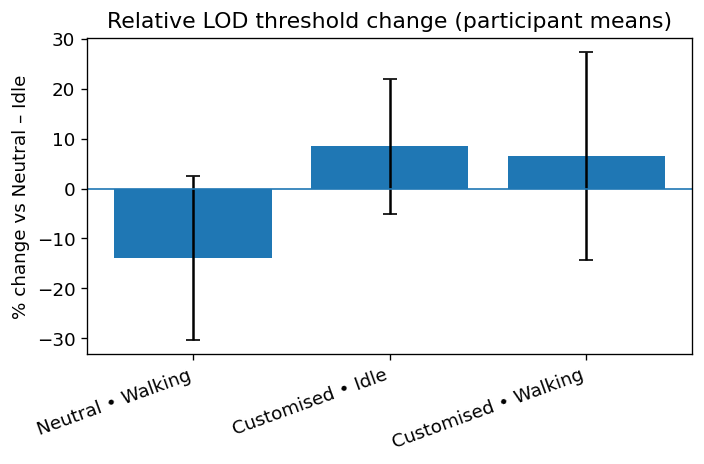

In [13]:
# --- Relative view vs baseline (Neutral • Idle) ---
df = cond_stats.copy()  # from Cell 6
df["condition"] = df["avatar"] + " • " + df["motion"]

# Baseline = Neutral • Idle  (safe extraction; avoids FutureWarning)
base = df.loc[(df["avatar"]=="Neutral") & (df["motion"]=="Idle"), "mean"].iloc[0]

# Relative deltas (%), simple CI transform (ignores baseline uncertainty)
df["delta_lod_vs_baseline"] = df["mean"] - base
df["pct_vs_baseline"] = (df["mean"] / base - 1.0) * 100.0
df["pct_lo"] = (df["lo"] / base - 1.0) * 100.0
df["pct_hi"] = (df["hi"] / base - 1.0) * 100.0

# Use the SAME delimiter (" • ") everywhere to avoid NaNs in categories
order = ["Neutral • Idle","Neutral • Walking","Customised • Idle","Customised • Walking"]
df["condition"] = pd.Categorical(df["condition"], categories=order, ordered=True)

view = (
    df.sort_values("condition")[
        ["condition","mean","lo","hi","delta_lod_vs_baseline","pct_vs_baseline","pct_lo","pct_hi"]
    ]
    .round(3)
)

# Save table
Path("tables").mkdir(exist_ok=True); Path("figures").mkdir(exist_ok=True)
view.to_excel("tables/relative_thresholds_from_means.xlsx", index=False)

# Plot using integer positions (avoids matplotlib categorical/NaN issues)
plot_df = view[view["condition"] != "Neutral • Idle"].copy()
x = np.arange(len(plot_df))
y = plot_df["pct_vs_baseline"].to_numpy()
yerr = np.vstack([y - plot_df["pct_lo"].to_numpy(), plot_df["pct_hi"].to_numpy() - y])

plt.figure(figsize=(6,4))
plt.bar(x, y, yerr=yerr, capsize=4)
plt.axhline(0, linewidth=1)
plt.ylabel("% change vs Neutral – Idle")
plt.title("Relative LOD threshold change (participant means)")
plt.xticks(x, plot_df["condition"], rotation=20, ha="right")
plt.tight_layout()
plt.savefig("figures/rel_change_from_cond_stats.png", dpi=200)
plt.show()


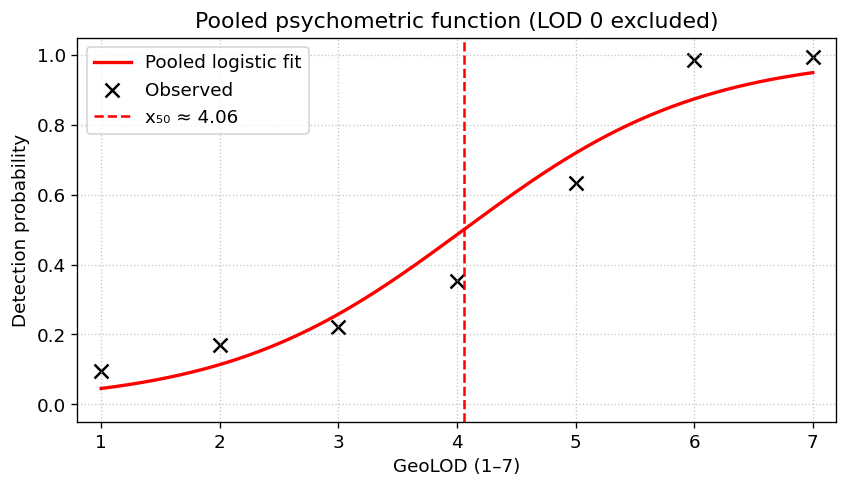

Pooled x50 ≈ 4.06  (approx 95% CI [3.93, 4.19])


In [14]:
# --- Cell 7: pooled logistic sigmoid over everyone/conditions ---

g = model_df.dropna(subset=["GeoLOD","detect"]).copy()
X = sm.add_constant(g["GeoLOD"].astype(float))
y = g["detect"].astype(int)
fit = sm.GLM(y, X, family=sm.families.Binomial()).fit()

b0 = float(fit.params["const"])
b1 = float(fit.params["GeoLOD"])
cov = fit.cov_params().loc[["const","GeoLOD"],["const","GeoLOD"]].to_numpy()
x50, se, lo, hi = delta_method_threshold(b0, b1, cov)

xs = np.linspace(1, 7, 400)
ps = 1/(1 + np.exp(-(b0 + b1*xs)))
obs = g.groupby("GeoLOD")["detect"].mean()

plt.figure(figsize=(7.2, 4.2))
plt.plot(xs, ps, "r-", lw=2, label="Pooled logistic fit")
plt.scatter(obs.index, obs.values, c="k", marker="x", s=70, label="Observed")
plt.axvline(x50, color="r", ls="--", lw=1.5, label=f"x₅₀ ≈ {x50:.2f}")
plt.title("Pooled psychometric function (LOD 0 excluded)")
plt.xlabel("GeoLOD (1–7)"); plt.ylabel("Detection probability")
plt.xlim(0.8, 7.2); plt.ylim(-0.05, 1.05); plt.grid(True, ls=":", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR/"fig_pooled_sigmoid.png", bbox_inches="tight")
plt.show()

print(f"Pooled x50 ≈ {x50:.2f}  (approx 95% CI [{lo:.2f}, {hi:.2f}])")


In [17]:
# --- Cell: Export EVERYTHING to .xlsx (individual files + multi-sheet workbook; embed figures if possible) ---

# Detect an Excel writer engine
try:
    import openpyxl  # engine + image embedding
    EXCEL_ENGINE = "openpyxl"
    HAVE_OPENPYXL = True
except Exception:
    HAVE_OPENPYXL = False
    try:
        import xlsxwriter  # engine + image embedding
        EXCEL_ENGINE = "xlsxwriter"
    except Exception:
        EXCEL_ENGINE = None

if EXCEL_ENGINE is None:
    print("[note] No Excel engine found. Install one of these to enable .xlsx export:")
    print("  pip install openpyxl   (recommended)   OR   pip install XlsxWriter")
else:
    print(f"[ok] Using Excel engine: {EXCEL_ENGINE}")

OUT_DIR = Path("./results")
OUT_DIR.mkdir(exist_ok=True)

# Collect tables from memory if present; otherwise try to reload from CSVs in results/
def get_table(name):
    obj = globals().get(name)
    if isinstance(obj, pd.DataFrame):
        return obj.copy()
    csv_path = OUT_DIR / f"{name}.csv"
    if csv_path.exists():
        try:
            return pd.read_csv(csv_path)
        except Exception:
            pass
    return None

# Map "sheet/file names" -> dataframe variables created earlier in the notebook
tables = {
    "qc_summary": get_table("qc"),
    "descriptives_by_lod": get_table("desc"),
    "thresholds_by_participant_condition": get_table("thr"),
    "thresholds_means_by_condition": get_table("cond_stats"),
    "pooled_thresholds_by_condition": get_table("pooled_cond_thr"),  # created by the sigmoid copy cell
}

# 1) Save each table as its own .xlsx
written = []
if EXCEL_ENGINE is not None:
    for stem, df in tables.items():
        if df is None or len(df) == 0:
            continue
        # If a Series slipped in, normalise to 2 cols
        if isinstance(df, pd.Series):
            df = df.to_frame(name="value").reset_index().rename(columns={"index": "metric"})
        xlsx_path = OUT_DIR / f"{stem}.xlsx"
        with pd.ExcelWriter(xlsx_path, engine=EXCEL_ENGINE) as w:
            df.to_excel(w, sheet_name="Sheet1", index=False)
        written.append(xlsx_path.name)
    print("[ok] Wrote individual workbooks:", ", ".join(written) if written else "(none)")

# 2) Multi-sheet workbook with all tables, plus a 'Figures' sheet if images exist
if EXCEL_ENGINE is not None:
    multi = OUT_DIR / "results_all.xlsx"
    with pd.ExcelWriter(multi, engine=EXCEL_ENGINE) as w:
        # Write each table to its own sheet
        for stem, df in tables.items():
            if df is None or len(df) == 0:
                continue
            if isinstance(df, pd.Series):
                df = df.to_frame(name="value").reset_index().rename(columns={"index": "metric"})
            sheet = stem[:31].replace(":", "_").replace("/", "_")
            df.to_excel(w, sheet_name=sheet, index=False)

        # Try to embed figures into a dedicated sheet
        figs = [
            OUT_DIR / "fig_descriptives_by_lod.png",
            OUT_DIR / "fig_sigmoids_by_lod.png",
            OUT_DIR / "fig_pooled_sigmoid.png",
        ]
        figs = [p for p in figs if p.exists()]
        if figs:
            sheet_name = "Figures"
            if EXCEL_ENGINE == "xlsxwriter":
                w.book.add_worksheet(sheet_name)
                ws = w.sheets[sheet_name]
                row = 0
                for fp in figs:
                    # Insert each image with some spacing
                    ws.insert_image(row, 0, str(fp))
                    row += 35  # move down for the next figure (tweak if needed)
            elif EXCEL_ENGINE == "openpyxl":
                from openpyxl.drawing.image import Image as XLImage
                # Ensure the sheet exists
                try:
                    _ = w.book[sheet_name]
                except KeyError:
                    w.book.create_sheet(title=sheet_name)
                ws = w.book[sheet_name]
                # Add images stacked vertically
                current_row = 1
                for fp in figs:
                    try:
                        img = XLImage(str(fp))
                        cell = f"A{current_row}"
                        ws.add_image(img, cell)
                        # Bump the anchor row; rough spacing between images
                        current_row += 45
                    except Exception as e:
                        print(f"[warn] Could not embed image {fp.name}: {e}")
            else:
                pass
    print(f"[ok] Wrote multi-sheet workbook with figures: {multi}")

if EXCEL_ENGINE is None:
    for stem, df in tables.items():
        if df is not None and len(df) > 0:
            df.to_csv(OUT_DIR / f"{stem}.csv", index=False)
    print("[note] Saved CSV copies only (no Excel engine available).")


[ok] Using Excel engine: openpyxl
[ok] Wrote individual workbooks: descriptives_by_lod.xlsx, thresholds_by_participant_condition.xlsx, thresholds_means_by_condition.xlsx, pooled_thresholds_by_condition.xlsx
[ok] Wrote multi-sheet workbook with figures: results\results_all.xlsx


Excluded 3 mis-fit thresholds → saved to threshold_misfits_excluded.csv


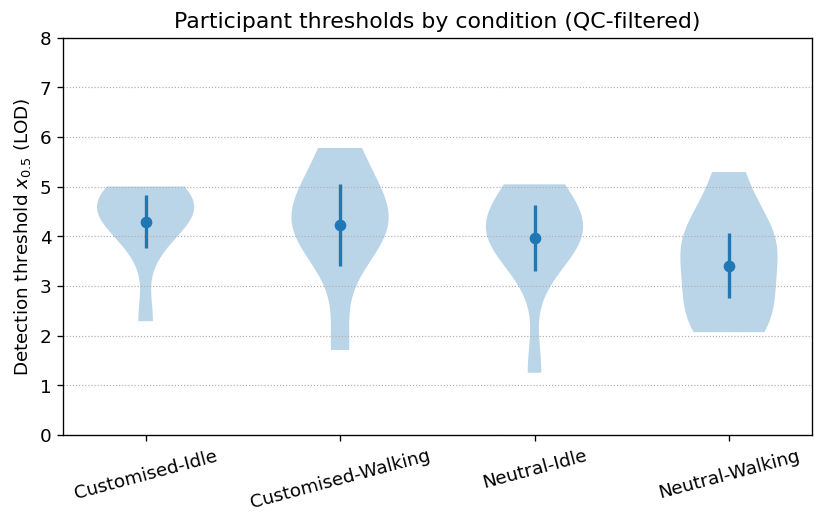

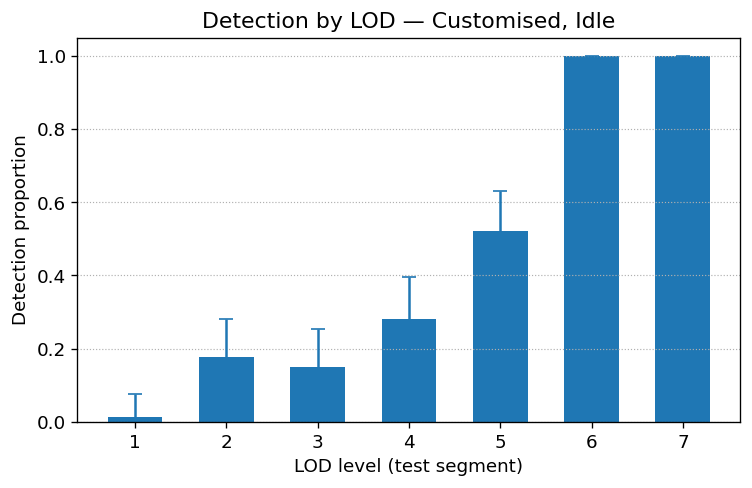

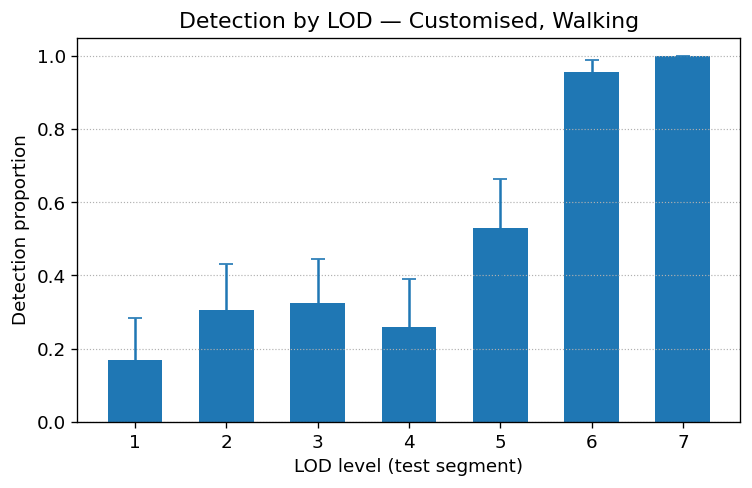

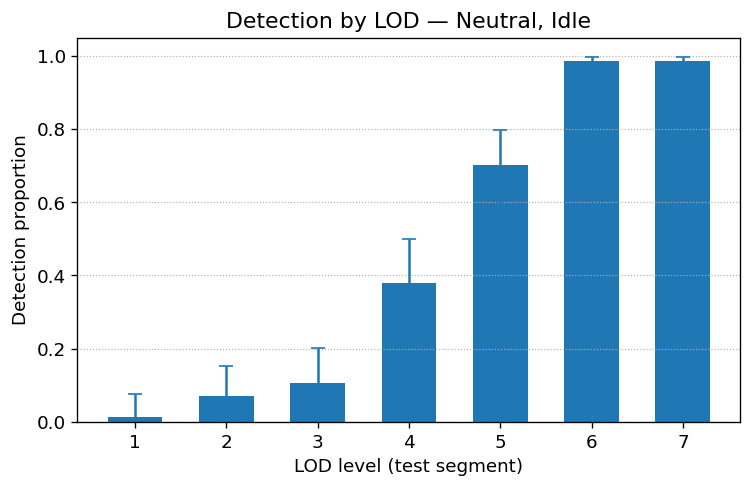

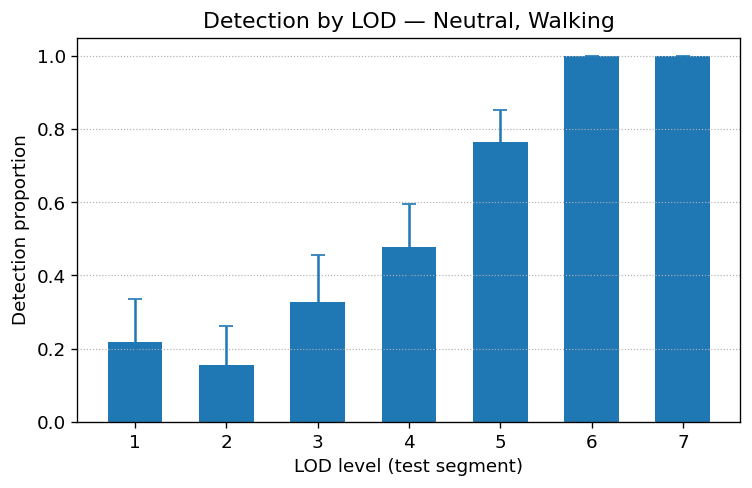

In [16]:
# --- Violin of participant thresholds by condition (QC-filtered) ---

thr = get_table("thresholds_by_participant_condition").copy()

qc = get_table("qc_summary")
if qc is not None and "include_confirmatory" in qc.columns:
    thr = thr.merge(qc[["ParticipantID","include_confirmatory"]], on="ParticipantID", how="left")
    thr = thr[(thr["include_confirmatory"] == True) | (thr["include_confirmatory"].isna())]

# QC rules: positive slope and plausible x50 in LOD range
rng_lo, rng_hi = 0.5, 7.5
mask = (thr["b1"] > 0) & (thr["x50"].between(rng_lo, rng_hi))

# Save and report excluded mis-fits for transparency (appendix-ready)
excluded = thr.loc[~mask, ["ParticipantID","avatar","motion","x50","x50_lo","x50_hi","b1"]].copy()
if len(excluded):
    excluded.to_csv(OUT_DIR / "threshold_misfits_excluded.csv", index=False)
    print(f"Excluded {len(excluded)} mis-fit thresholds → saved to threshold_misfits_excluded.csv")

thr_plot = thr.loc[mask].copy()
thr_plot["condition"] = thr_plot["avatar"].astype(str) + "-" + thr_plot["motion"].astype(str)
cond_order = ["Customised-Idle", "Customised-Walking", "Neutral-Idle", "Neutral-Walking"]
thr_plot["condition"] = pd.Categorical(thr_plot["condition"], categories=cond_order, ordered=True)
thr_plot = thr_plot.sort_values("condition")

# Build violin data (no seaborn; single plot)
data = [thr_plot.loc[thr_plot["condition"] == c, "x50"].dropna().values for c in cond_order]

fig = plt.figure(figsize=(7.0, 4.5)); ax = plt.gca()
ax.violinplot(dataset=data, showmeans=False, showmedians=False, showextrema=False)

# Overlay means and ~95% CIs
means = [np.mean(d) if len(d) else np.nan for d in data]
sds   = [np.std(d, ddof=1) if len(d) > 1 else np.nan for d in data]
ns    = [len(d) for d in data]
cis   = [1.96 * (sd / np.sqrt(n)) if (n > 1 and np.isfinite(sd)) else np.nan for sd, n in zip(sds, ns)]

x = np.arange(1, len(cond_order) + 1)
ax.scatter(x, means, zorder=3)
for xi, m, ci in zip(x, means, cis):
    if np.isfinite(m) and np.isfinite(ci):
        ax.vlines(xi, m - ci, m + ci, linewidth=2, zorder=2)

ax.set_xticks(x); ax.set_xticklabels(cond_order, rotation=15)
ax.set_ylabel(r"Detection threshold $x_{0.5}$ (LOD)")
ax.set_title("Participant thresholds by condition (QC-filtered)")
ax.set_ylim(rng_lo - 0.5, rng_hi + 0.5)
ax.grid(axis='y', linestyle=':', linewidth=0.7)

plt.tight_layout()
plt.savefig(OUT_DIR / "fig_violin_thresholds_by_condition.png", dpi=300, bbox_inches="tight")
plt.show()

# ----

# --- Detection by LOD with 95% CIs (bars), per condition ---

desc = get_table("descriptives_by_lod")
assert desc is not None, "descriptives_by_lod not found. Run the descriptives cell first."

desc = desc.copy().sort_values(["avatar", "motion", "GeoLOD"])

for av in ["Customised", "Neutral"]:
    for mo in ["Idle", "Walking"]:
        sub = desc[(desc["avatar"] == av) & (desc["motion"] == mo)]
        if sub.empty:
            continue

        xs = sub["GeoLOD"].values
        p  = sub["p"].values.astype(float)
        lo = sub["p_lo"].values.astype(float)
        hi = sub["p_hi"].values.astype(float)

        # Ensure non-negative symmetric errors
        lo = np.minimum(lo, p)
        hi = np.maximum(hi, p)
        yerr = np.vstack([np.maximum(0, p - lo), np.maximum(0, hi - p)])

        fig = plt.figure(figsize=(6.4, 4.2))
        ax = plt.gca()
        ax.bar(xs, p, width=0.6)
        ax.errorbar(xs, p, yerr=yerr, fmt='none', linewidth=1.5, capsize=4)
        ax.set_xlabel("LOD level (test segment)")
        ax.set_ylabel("Detection proportion")
        ax.set_title(f"Detection by LOD — {av}, {mo}")
        ax.set_ylim(0, 1.05)
        ax.set_xticks(xs)
        ax.grid(axis='y', linestyle=':', linewidth=0.7)

        plt.tight_layout()
        plt.savefig(OUT_DIR / f"fig_bars_detect_by_lod_{av}_{mo}.png", dpi=300, bbox_inches="tight")
        plt.show()
